In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [2]:
dataset = "../model/keypoint_classifier/large_keypoint.csv"
model_save_path = '../model/keypoint_classifier/large_keypoint.hdf5'
tflite_save_path = '../model/keypoint_classifier/large_keypoint.tflite'

# Set number of classes

In [3]:
NUM_CLASSES = 8

# Dataset reading

In [4]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
import numpy as np
import pandas as pd


# Read the dataset from the CSV file
data = pd.read_csv(dataset)

# Specify the target variable
balance_by = data.columns[0]

# Function to determine the sampling strategy
def sampling_strategy(X, y, n_samples, t='majority'):
    target_classes = ''
    if t == 'majority':
        target_classes = y.value_counts() > n_samples
    elif t == 'minority':
        target_classes = y.value_counts() < n_samples
    tc = target_classes[target_classes == True].index
    sampling_strategy = {}
    for target in tc:
        sampling_strategy[target] = n_samples
    return sampling_strategy

# Calculate the median count for balancing
n_samples = int(data[balance_by].value_counts().median())

# Balancing the data using RandomUnderSampler and RandomOverSampler
under_sampler = RandomUnderSampler(sampling_strategy=sampling_strategy(data.drop(balance_by, axis=1), data[balance_by], n_samples, t='majority'))
X_under, y_under = under_sampler.fit_resample(data.drop(balance_by, axis=1), data[balance_by])

over_sampler = RandomOverSampler(sampling_strategy=sampling_strategy(X_under, y_under, n_samples, t='minority'))
X_bal, y_bal = over_sampler.fit_resample(X_under, y_under)

balanced_data = pd.DataFrame(X_bal)
balanced_data[balance_by] = y_bal

# Print class distribution before resampling
unique_classes_before, class_counts_before = np.unique(data[balance_by], return_counts=True)
print("Class distribution before resampling:")
for class_label, count in zip(unique_classes_before, class_counts_before):
    print(f"Class {class_label}: {count} instances")

# Print class distribution after resampling
unique_classes_after, class_counts_after = np.unique(balanced_data[balance_by], return_counts=True)
print("\nClass distribution after resampling:")
for class_label, count in zip(unique_classes_after, class_counts_after):
    print(f"Class {class_label}: {count} instances")


Class distribution before resampling:
Class 0: 3815 instances
Class 1: 5103 instances
Class 2: 5176 instances
Class 3: 3276 instances
Class 4: 3196 instances
Class 5: 3260 instances
Class 6: 3270 instances
Class 7: 3799 instances

Class distribution after resampling:
Class 0: 3537 instances
Class 1: 3537 instances
Class 2: 3537 instances
Class 3: 3537 instances
Class 4: 3537 instances
Class 5: 3537 instances
Class 6: 3537 instances
Class 7: 3537 instances


In [5]:
balanced_data.head()

,0.0,0.0.1,0.23605150214592274,-0.3776824034334764,0.30472103004291845,-0.630901287553648,0.3605150214592275,-0.8412017167381974,0.2832618025751073,-0.9957081545064378,...,-0.5150214592274678,-0.2017167381974249,-0.5793991416309013,0.11158798283261803,-0.6738197424892703.1,0.15450643776824036,-0.51931330472103,0.04721030042918455,-0.4592274678111588,0
0,0.0,0.0,0.358491,-0.018868,0.801887,-0.216981,0.886792,-0.566038,0.641509,-0.764151,...,-0.613208,-0.075472,-0.924528,-0.113208,-1.000000,-0.122642,-0.745283,-0.084906,-0.698113,0
1,0.0,0.0,-0.358382,-0.156069,-0.635838,-0.387283,-0.676301,-0.687861,-0.433526,-0.803468,...,-0.445087,0.323699,-0.664740,0.231214,-0.849711,0.196532,-0.606936,0.219653,-0.502890,0
2,0.0,0.0,0.352273,-0.227273,0.590909,-0.511364,0.613636,-0.784091,0.431818,-0.863636,...,-0.613636,0.102273,-0.806818,0.181818,-0.931818,0.147727,-0.738636,0.136364,-0.636364,0
3,0.0,0.0,-0.344498,-0.148325,-0.626794,-0.373206,-0.751196,-0.660287,-0.602871,-0.856459,...,-0.526316,0.287081,-0.631579,0.210526,-0.837321,0.110048,-0.617225,0.100478,-0.497608,0
4,0.0,0.0,0.183908,-0.168582,0.287356,-0.367816,0.310345,-0.559387,0.279693,-0.693487,...,-0.747126,-0.095785,-0.685824,-0.111111,-0.854406,-0.065134,-0.858238,-0.030651,-0.762452,0


30895


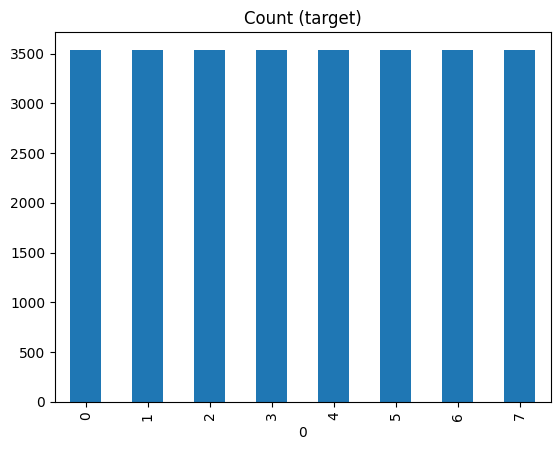

In [29]:
print(data["0"].count())
balanced_data["0"].value_counts().plot(kind='bar', title='Count (target)');

In [6]:
X_dataset = np.array(balanced_data.drop(balance_by, axis=1))
X_dataset

array([[ 0.        ,  0.        ,  0.35849057, ..., -0.74528302,
        -0.08490566, -0.69811321],
       [ 0.        ,  0.        , -0.3583815 , ..., -0.60693642,
         0.21965318, -0.50289017],
       [ 0.        ,  0.        ,  0.35227273, ..., -0.73863636,
         0.13636364, -0.63636364],
       ...,
       [ 0.        ,  0.        , -0.34166667, ..., -0.54166667,
         0.39166667, -0.375     ],
       [ 0.        ,  0.        ,  0.29299363, ..., -0.4522293 ,
        -0.13375796, -0.40127389],
       [ 0.        ,  0.        ,  0.24110672, ..., -0.52964427,
        -0.31620553, -0.54940711]])

In [7]:
y_dataset = np.array(balanced_data[balance_by])
y_dataset

array([0, 0, 0, ..., 6, 6, 6], dtype=int64)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [9]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [10]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 20)                860       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 8)                 88        
                                                                 
Total params: 1158 (4.52 KB)
Trainable params: 1158 (4.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [12]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [13]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000


165/166 [============================>.] - ETA: 0s - loss: 1.8336 - accuracy: 0.2893
Epoch 1: saving model to ../model/keypoint_classifier\large_keypoint.hdf5
166/166 [==============================] - 2s 5ms/step - loss: 1.8325 - accuracy: 0.2900 - val_loss: 1.3953 - val_accuracy: 0.5766
Epoch 2/1000
 76/166 [============>.................] - ETA: 0s - loss: 1.4460 - accuracy: 0.4632

c:\Year 3\FYP\Modelling\fyp_modelling\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


161/166 [============================>.] - ETA: 0s - loss: 1.3710 - accuracy: 0.4871
Epoch 2: saving model to ../model/keypoint_classifier\large_keypoint.hdf5
166/166 [==============================] - 0s 3ms/step - loss: 1.3675 - accuracy: 0.4884 - val_loss: 1.0510 - val_accuracy: 0.6392
Epoch 3/1000
153/166 [==========================>...] - ETA: 0s - loss: 1.1900 - accuracy: 0.5588
Epoch 3: saving model to ../model/keypoint_classifier\large_keypoint.hdf5
166/166 [==============================] - 0s 3ms/step - loss: 1.1855 - accuracy: 0.5627 - val_loss: 0.9158 - val_accuracy: 0.7214
Epoch 4/1000
162/166 [============================>.] - ETA: 0s - loss: 1.0813 - accuracy: 0.6138
Epoch 4: saving model to ../model/keypoint_classifier\large_keypoint.hdf5
166/166 [==============================] - 1s 3ms/step - loss: 1.0795 - accuracy: 0.6142 - val_loss: 0.8171 - val_accuracy: 0.7347
Epoch 5/1000
152/166 [==========================>...] - ETA: 0s - loss: 1.0151 - accuracy: 0.6435
Epoch 

In [14]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

56/56 [==============================] - 0s 1ms/step - loss: 0.5984 - accuracy: 0.8150


In [15]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [16]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 89ms/step
[6.70723850e-04 5.27043404e-08 1.50187961e-05 3.82374965e-05
 1.38223395e-02 1.61866844e-01 8.23586822e-01 2.68835704e-10]
6


# Confusion matrix

In [17]:
series = pd.Series(y_test)

# Use the value_counts method
value_counts_result = series.value_counts()

print(value_counts_result)


5    910
0    896
4    886
6    884
3    878
2    877
7    873
1    870
Name: count, dtype: int64


222/222 [==============================] - 0s 1ms/step
[0, 1, 2, 3, 4, 5, 6, 7]


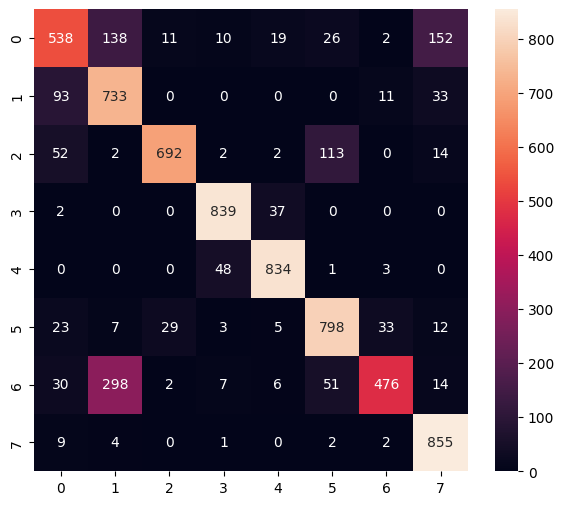

Classification Report
              precision    recall  f1-score   support

           0       0.72      0.60      0.65       896
           1       0.62      0.84      0.71       870
           2       0.94      0.79      0.86       877
           3       0.92      0.96      0.94       878
           4       0.92      0.94      0.93       886
           5       0.81      0.88      0.84       910
           6       0.90      0.54      0.67       884
           7       0.79      0.98      0.88       873

    accuracy                           0.81      7074
   macro avg       0.83      0.82      0.81      7074
weighted avg       0.83      0.81      0.81      7074



In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    print(labels)
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [19]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

c:\Year 3\FYP\Modelling\fyp_modelling\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [20]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\SHERMA~1\AppData\Local\Temp\tmp9ounbuow\assets


INFO:tensorflow:Assets written to: C:\Users\SHERMA~1\AppData\Local\Temp\tmp9ounbuow\assets


6720

# Inference test

In [21]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [22]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [23]:
input_data = np.array([X_test[0]], dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)

In [24]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 1 ms


In [25]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[6.70723792e-04 5.27043262e-08 1.50187925e-05 3.82374892e-05
 1.38223516e-02 1.61866888e-01 8.23586702e-01 2.68835620e-10]
6


In [26]:
y_test[0]

6